In [1]:
%matplotlib inline


# Comparison of Manifold Learning methods


An illustration of dimensionality reduction with various manifold learning methods.


Note that the purpose of the MDS is to find a low-dimensional
representation of the data (here 2D) in which the distances respect well
the distances in the original high-dimensional space, unlike other
manifold-learning algorithms, it does not seeks an isotropic
representation of the data in the low-dimensional space.



### Package dependencies

In [67]:
!pip install networkx
!conda install -c conda-forge keras 
!conda install -c conda-forge umap-learn 
!conda install -c conda-forge keras 

Solving environment: - ^C
failed

CondaError: KeyboardInterrupt



### Add path to elpigraph package

In [1]:
import sys
sys.path.append('/home/utilisateur/ElpiGraph.Tensorflow2_eager/')
sys.path.append('/home/utilisateur/ElpiGraph.Tensorflow2_eager/elpigraph/core_algorithm/')

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

import networkx as nx
from elpigraph import *
from PartitionData import PartitionData
from sklearn import manifold, datasets
from sklearn.neighbors import NearestNeighbors
from umap import UMAP
from keras.layers import Input, Dense
from keras.models import Model

### Comparison

standard: 0.47 sec
ltsa: 0.96 sec
hessian: 1.3 sec
modified: 0.87 sec
Isomap: 2 sec
MDS: 10 sec
SpectralEmbedding: 0.41 sec
t-SNE: 7.6 sec
UMAP: 5.5 sec
Iteration:  1
Performing PCA on the data
Computing EPG with  36  nodes on  1584  points and  10  dimensions
NODE:
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 
E= 0.02246630942804126 , MSE= 0.010753283674310218 , EP= 0.010601068200084166 , RP= 0.001111957553646876
Done
ElPiGraph: 64 sec


/home/utilisateur/.conda/envs/Tensorflow/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


Autoencoder: 11 sec


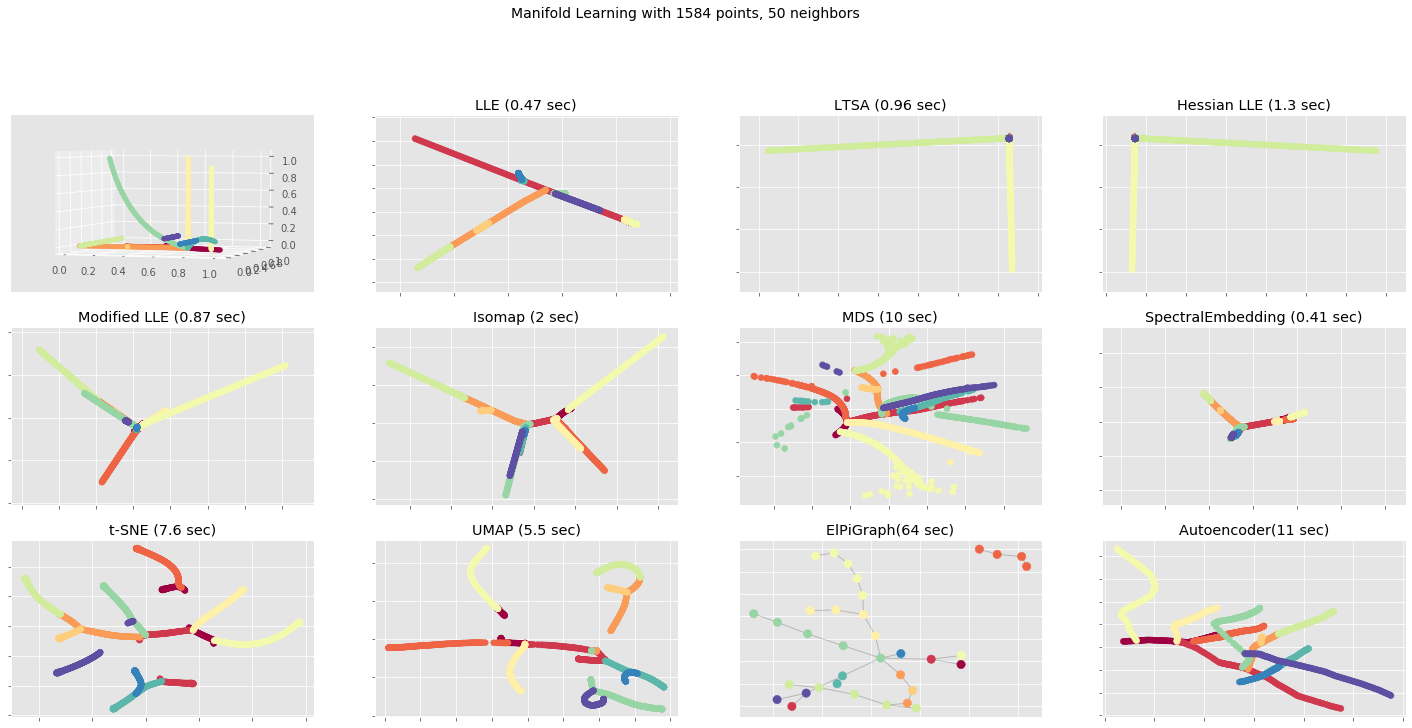

In [62]:
# Next line to silence pyflakes. This import is needed.
Axes3D

X = np.loadtxt('examples/ext10_10_2.txt');
color = np.loadtxt('examples/ext10_10_2.irx').astype('int')
n_points = X.shape[0]
#color = np.full((n_points,),1)
#color[0:49] = 2
#color[50:99] = -1
n_points = X.shape[0]
n_neighbors = 50
n_components = 2

fig = plt.figure(figsize=(25, 15))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (n_points, n_neighbors), fontsize=14)


ax = fig.add_subplot(441, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)

methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(4,4,2 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(446)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(447)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(448)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(4,4,9)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
um = UMAP(n_neighbors=n_neighbors,
          n_components=n_components)
Y = um.fit_transform(X)
t1 = time()
print("UMAP: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(4,4,10)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("UMAP (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


### ElPiGraph ###

nnodes = 12*3

#heuristic to decide optional trimming radius
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

t0 = time()
NodeP, EM, Edges = computeElasticPrincipalTree.computeElasticPrincipalTree(X,nnodes,TrimmingRadius=np.inf)
NodeP, Edges = NodeP.squeeze(), Edges.squeeze()
t1 = time()
print("ElPiGraph: %.2g sec" % (t1 - t0))

#compute datapoint to associate with each node
partition, dists = PartitionData(X,NodeP,MaxBlockSize=10**6, SquaredX=(X**2).sum(axis=1).reshape((X.shape[0], 1)))

#remove nodes with no associated datapoint
empty_nodes = list(set(range(nnodes))-set(np.unique(partition)))
Edges2=Edges
ind_to_del = []
for i in range(Edges.shape[1]):
    if (Edges2[0,i] in empty_nodes) or (Edges2[1,i] in empty_nodes):
        ind_to_del.append(i)
Edges2 = np.delete(Edges,ind_to_del,axis=1)

#associate color(s) to nodes
pie_col_nodes = []
main_col_nodes = []
for i0,i in enumerate(np.unique(partition)):
    pie_col_nodes.append(color[np.where(partition.squeeze()==i)[0]])
    main_col_nodes.append(np.argmax(np.bincount(pie_col_nodes[i0])))

### Draw graph
ax = fig.add_subplot(4,4,11)

g=nx.Graph()
g.add_edges_from(Edges2.T)
pos = nx.spring_layout(g,scale=2)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos,
                            nodelist=list(np.unique(partition)),
                            node_color=main_col_nodes, 
                            node_size=70,
                            cmap=plt.cm.Spectral)



plt.title("ElPiGraph(%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


### Autoencoder ###

layer_sizes = [64,32,16,8]
#encoder
inputs = Input(shape=(X.shape[1],), name='encoder_input')
x = inputs
for size in layer_sizes:
    x = Dense(size, activation='relu',kernel_initializer='he_uniform')(x)
latent = Dense(n_components,kernel_initializer='he_uniform', name='latent_vector')(x)
encoder = Model(inputs, latent, name='encoder')

#decoder
latent_inputs = Input(shape=(n_components,), name='decoder_input')
x = latent_inputs
for size in layer_sizes[::-1]:
    x = Dense(size, activation='relu',kernel_initializer='he_uniform')(x)
outputs = Dense(X.shape[1] ,activation='sigmoid',kernel_initializer='he_uniform',name='decoder_output')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

#autoencoder
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

#model summary
# encoder.summary()
# decoder.summary()
# autoencoder.summary()
X_01 = (X-X.min())/(X.max()-X.min())
autoencoder.compile(loss='mse', optimizer='adam')
t0 = time()
autoencoder.fit(x=X_01,y=X_01,epochs=100,verbose=0)
Y = encoder.predict(X)
t1 = time()
print("Autoencoder: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(4,4,12)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Autoencoder(%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

### Testing ElPiGraph viz, R version

In [35]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [66]:
%%R
library(ElPiGraph.R)
library(igraph)

nnodesR <- 60
data <- read.table('examples/ext10_10_2.txt',header=FALSE,sep="\t")
data <- as.matrix(data)
TreeEPG <- computeElasticPrincipalTree(X = data, NumNodes = nnodes,
                                       drawAccuracyComplexity = FALSE, 
                                       drawEnergy = FALSE,
                                       verbose = FALSE,
                                       drawPCAView = FALSE)

NodePR <- TreeEPG[[1]]$NodePositions
EdgesR <- TreeEPG[[1]]$Edges$Edges

[1] "Generating the initial configuration"
[1] "Creating a chain in the 1st PC with 2 nodes"
[1] "Constructing tree 1 of 1 / Subset 1 of 1"
[1] "Performing PCA on the data"
[1] "Using standard PCA"
[1] "10 dimensions are being used"
[1] "100% of the original variance has been retained"
[1] "The elastic matrix is being used. Edge configuration will be ignored"
[1] "Computing EPG with 40 nodes on 1584 points and 10 dimensions"
[1] "Using a single core"
Nodes = 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 
BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD
1|0|0|1|5||40	0.02155	40	39	19	5	0	0	0.01056	0.009129	0.9594	0.9649	0.01087	0.0001188	0.004753	0.1901	0
26.966 sec elapsed


In [67]:
%R -o NodePR -o EdgesR -o nnodesR

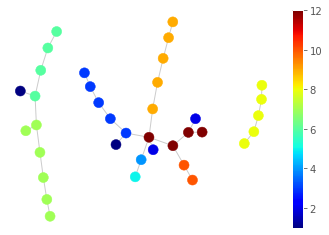

In [68]:
NodeP = np.array(NodePR)
Edges = np.array(EdgesR).T-1
nnodes = int(nnodesR[0])

#compute datapoint to associate with each node
partition, dists = PartitionData(X,NodeP,MaxBlockSize=10**6, SquaredX = (X**2).sum(axis=1).reshape((X.shape[0], 1)))

#remove nodes with no associated datapoint
empty_nodes = list(set(range(nnodes))-set(np.unique(partition)))
Edges2=Edges
ind_to_del = []
for i in range(Edges.shape[1]):
    if (Edges[0,i] in empty_nodes) or (Edges[1,i] in empty_nodes):
        ind_to_del.append(i)
Edges2 = np.delete(Edges,ind_to_del,axis=1)

#associate color(s) to nodes
pie_col_nodes = []
main_col_nodes = []
for i0,i in enumerate(np.unique(partition)):
    pie_col_nodes.append(color[np.where(partition.squeeze()==i)[0]])
    main_col_nodes.append(np.argmax(np.bincount(pie_col_nodes[i0])))

### Draw graph
g=nx.Graph()
g.add_edges_from(Edges2.T)
pos = nx.spring_layout(g,scale=2)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos,
                            nodelist=list(np.unique(partition)),
                            node_color=main_col_nodes, 
                            node_size=100,
                            cmap=plt.cm.jet)


plt.colorbar(nc)
plt.axis('off')
plt.show()

### Testing ElPiGraph viz, Python version

Iteration:  1
Performing PCA on the data
Computing EPG with  4  nodes on  1584  points and  10  dimensions
NODE:
2 3 
E= 0.14217127742608165 , MSE= 0.1282188121215279 , EP= 0.005735978673276961 , RP= 0.008216486631276807
Done


/home/utilisateur/.conda/envs/Tensorflow/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


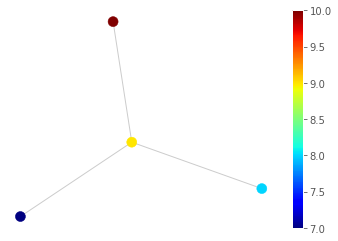

In [64]:
X = np.loadtxt('examples/ext10_10_2.txt')
nnodes = 40

#heuristic to decide optional trimming radius + optional knn tree/MST display
nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
# g=nx.Graph()
# g.add_edges_from(indices)
# pos = nx.spring_layout(g,scale=2)
# ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
# nc = nx.draw_networkx_nodes(g, pos,
#                             nodelist=list(np.unique(indices)),
#                             node_color=color, 
#                             node_size=100,
#                             cmap=plt.cm.jet)
# T=nx.minimum_spanning_tree(g)
# plt.colorbar(nc)
# plt.axis('off')
# plt.show()

#run elpigraph
NodeP, EM, Edges = computeElasticPrincipalTree.computeElasticPrincipalTree(X,nnodes,TrimmingRadius=np.inf)
NodeP, Edges = NodeP.squeeze(), Edges.squeeze()

#compute datapoint to associate with each node
partition, dists = PartitionData(X,NodeP,MaxBlockSize=10**6, SquaredX = (X**2).sum(axis=1).reshape((X.shape[0], 1)))

#remove nodes with no associated datapoint
empty_nodes = list(set(range(nnodes))-set(np.unique(partition)))
Edges2=Edges
ind_to_del = []
for i in range(Edges.shape[1]):
    if (Edges[0,i] in empty_nodes) or (Edges[1,i] in empty_nodes):
        ind_to_del.append(i)
Edges2 = np.delete(Edges,ind_to_del,axis=1)

#associate color(s) to nodes
pie_col_nodes = []
main_col_nodes = []
for i0,i in enumerate(np.unique(Edges2)):
    pie_col_nodes.append(color[np.where(partition.squeeze()==i)[0]])
    main_col_nodes.append(np.argmax(np.bincount(pie_col_nodes[i0])))

### Draw graph
g=nx.Graph()
g.add_edges_from(Edges2.T)
pos = nx.spring_layout(g,scale=2)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos,
                            nodelist=list(np.unique(Edges2)),
                            node_color=main_col_nodes, 
                            node_size=100,
                            cmap=plt.cm.jet)


plt.colorbar(nc)
plt.axis('off')
plt.show()